In [41]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt # matplotlib for plotting
import re # regular expressions
import warnings
warnings.filterwarnings("ignore") #because who likes annoying warnings

plt.style.use('ggplot') #prettier pictures

import datetime      #for datetime operations
import calendar      #for calendar for datetime operations
import time          #to get the system time
plt.rcParams['figure.figsize'] = [16, 10] #set default figure size

from sklearn.model_selection import train_test_split
from sklearn.linear_model  import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import xgboost as xgb


In [6]:
df = pd.read_csv('../data/clean_train.csv')

# Data Preparation for Modelling

Since we have a variety of data types within the dataset, we must wrangle them accordingly to get them ready for modelling.

- Get rid of irrelevant columns such as "id"
- Only use log_trip_duration instead of both the former and trip_duration (can't have pretty much the same variable as a predictor variable
- Use one hot encoding (pandas get_dummies) for the categorical varialbes such as "vendor_id", "passenger_count", varius date columns (day, week, month), and cluster labels
- Randomly split the data, assign predictor and target variables and train!


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436572 entries, 0 to 1436571
Data columns (total 26 columns):
Unnamed: 0                  1436572 non-null int64
id                          1436572 non-null object
vendor_id                   1436572 non-null int64
pickup_datetime             1436572 non-null object
dropoff_datetime            1436572 non-null object
passenger_count             1436572 non-null int64
pickup_longitude            1436572 non-null float64
pickup_latitude             1436572 non-null float64
dropoff_longitude           1436572 non-null float64
dropoff_latitude            1436572 non-null float64
store_and_fwd_flag          1436572 non-null int64
trip_duration               1436572 non-null int64
date                        1436572 non-null object
minimum temperature         1436572 non-null int64
precipitation               1436572 non-null float64
snow fall                   1436572 non-null float64
snow depth                  1436572 non-null float64
lo

In [4]:
#dropping id because it's irrelevant, dropping log_trip_duration so we can append to the end when we are ready

df = df.drop(['id','log_trip_duration'], 1) 

In [8]:
vendor_train = pd.get_dummies(df['vendor_id'], prefix='vi', prefix_sep='_')
passenger_count_train = pd.get_dummies(df['passenger_count'], prefix='pc', prefix_sep='_')
store_and_fwd_flag_train = pd.get_dummies(df['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
cluster_pickup_train = pd.get_dummies(df['pickup_cluster'], prefix='p', prefix_sep='_')
cluster_dropoff_train = pd.get_dummies(df['dropoff_cluster'], prefix='d', prefix_sep='_')
month_train = pd.get_dummies(df['Month'], prefix='m', prefix_sep='_')
hour_train = pd.get_dummies(df['Hour'], prefix='h', prefix_sep='_')
dow_train = pd.get_dummies(df['dayofweek'], prefix='dow', prefix_sep='_')

In [12]:
#drop the encoded variables, drop dropoff_datetime (because this is just counterintuitive to what we want to guess)
#and since there is not gonna be such a variable in the test set. 

#we could technically drop pickup & dropoff long/lat since it is somewhat generally encoded in the cluster label variables.

df = df.drop(['vendor_id','passenger_count','store_and_fwd_flag','Month','Hour','dayofweek',
             'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','dropoff_datetime'],axis = 1)

In [13]:
df_final = pd.concat([df,
                          vendor_train,
                          passenger_count_train,
                          store_and_fwd_flag_train,
                          cluster_pickup_train,
                          cluster_dropoff_train,
                          month_train,
                          hour_train,
                          dow_train
                         ], axis=1)

In [14]:
df_final['log_trip_duration'] = np.log(df['trip_duration'].values + 1)

In [17]:
#drop pickup_datetime and date, since it is in the dummy variables now. drop newly formed id and unamed 0 columns
#drop trip duration
df_final = df_final.drop(['trip_duration', 'pickup_datetime', 'date', 'id', 'Unnamed: 0'], 1)

In [19]:
df_final.shape

(1436572, 88)

# Linear Regression log_trip_prediction

In [20]:
#seperating into predictor and target variables

X = df_final.drop('log_trip_duration', 1) #every column except for log_trip_duration
y = df_final['log_trip_duration'] #target variable

In [21]:
#random splitting 
#set random state for deterministic random probabilities
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.2, random_state = 42)

In [23]:
model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [26]:
print("R^2: {}".format(model.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Log Squared Error: {}".format(rmse))

R^2: 0.5415466003435012
Root Mean Log Squared Error: 0.5185110000062806


Looking at the Root Mean Log Squared Error, it is still rather high. Hopefully we can get that down using some other modelling methods.

In [27]:
cv_scores = cross_val_score(model, X, y, cv= 5)
print(cv_scores)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[0.5387179  0.53663453 0.54098089 0.53994325 0.53896501]
Average 5-Fold CV Score: 0.5390483156898613


In [30]:
col_names = list(X.columns)
coef = list(model.coef_.astype(float))

In [32]:
show_coef = pd.DataFrame(
    {'Attributes': col_names,
     'Coefficients': coef})
show_coef.sort_values(by = 'Coefficients', ascending = False).head(10)

,Attributes,Coefficients
49,d_14,2.189030e+07
20,p_0,2.031527e+07
48,d_13,1.854618e+07
21,p_1,1.757684e+07
47,d_12,1.520207e+07
22,p_2,1.483840e+07
23,p_3,1.209997e+07
46,d_11,1.185795e+07
10,vi_2,1.139965e+07
9,vi_1,1.139965e+07


The one hot encoded variables for the pick up and drop off clusters come in as the highest coefficients when using linear regression to predict log_trip_duration. 

# XGBoost Predicting log_trip_duration

In [42]:
#using the same split of predictor and target variables as before.
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [47]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [53]:
#selecting parameteres for XGBoost algorithm. Will run until there is no improvement in 
#RMSE in 10 rounds
#uncomment and run (takes a long while though)



#md = [6]
#lr = [0.1, 0.3]
#mcw = [20,25,30]
#for m in md:
#    for l in lr:
#        for n in mcw:
#            xgb_pars = {'min_child_weight': n, 'eta': l, 'colsample_bytree': 0.9, 
#                        'max_depth': m, 'subsample': 0.9, 'lambda': 1., 'nthread': -1, 
#                        'booster' : 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
#            model = xgb.train(xgb_pars, dtrain, 50, watchlist, early_stopping_rounds=10, maximize=False, verbose_eval=1)

[0]	train-rmse:5.40235	valid-rmse:5.40288
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[1]	train-rmse:4.86613	valid-rmse:4.86654
[2]	train-rmse:4.38394	valid-rmse:4.38426
[3]	train-rmse:3.95039	valid-rmse:3.95066
[4]	train-rmse:3.56069	valid-rmse:3.56089
[5]	train-rmse:3.21058	valid-rmse:3.21073
[6]	train-rmse:2.89601	valid-rmse:2.89609
[7]	train-rmse:2.61361	valid-rmse:2.61367
[8]	train-rmse:2.36009	valid-rmse:2.36013
[9]	train-rmse:2.13273	valid-rmse:2.13273
[10]	train-rmse:1.92887	valid-rmse:1.92882
[11]	train-rmse:1.74634	valid-rmse:1.74624
[12]	train-rmse:1.58307	valid-rmse:1.58295
[13]	train-rmse:1.43732	valid-rmse:1.43717
[14]	train-rmse:1.30712	valid-rmse:1.30696
[15]	train-rmse:1.1914	valid-rmse:1.1912
[16]	train-rmse:1.0884	valid-rmse:1.08815
[17]	train-rmse:0.997113	valid-rmse:0.996867
[18]	train-rmse:0.916563	valid-rmse:0.916282
[19]	train-rmse:0.845226	valid-rmse:0.844921
[2

[24]	train-rmse:0.385307	valid-rmse:0.384649
[25]	train-rmse:0.383311	valid-rmse:0.382719
[26]	train-rmse:0.382471	valid-rmse:0.381909
[27]	train-rmse:0.381569	valid-rmse:0.381061
[28]	train-rmse:0.380639	valid-rmse:0.380451
[29]	train-rmse:0.379488	valid-rmse:0.379351
[30]	train-rmse:0.378932	valid-rmse:0.378848
[31]	train-rmse:0.377805	valid-rmse:0.377757
[32]	train-rmse:0.377033	valid-rmse:0.377071
[33]	train-rmse:0.376516	valid-rmse:0.376674
[34]	train-rmse:0.376004	valid-rmse:0.376243
[35]	train-rmse:0.375599	valid-rmse:0.375863
[36]	train-rmse:0.374799	valid-rmse:0.375081
[37]	train-rmse:0.374127	valid-rmse:0.374488
[38]	train-rmse:0.373651	valid-rmse:0.374028
[39]	train-rmse:0.372954	valid-rmse:0.373347
[40]	train-rmse:0.372556	valid-rmse:0.372966
[41]	train-rmse:0.371854	valid-rmse:0.372347
[42]	train-rmse:0.371578	valid-rmse:0.372082
[43]	train-rmse:0.371177	valid-rmse:0.371712
[44]	train-rmse:0.370871	valid-rmse:0.371469
[45]	train-rmse:0.370102	valid-rmse:0.370815
[46]	train

In [57]:
xgb_pars = {'min_child_weight': 1, 'eta': 0.3, 'colsample_bytree': 0.9, 
            'max_depth': 7, 'subsample': 0.9, 'lambda': 1., 'nthread': -1,
            'booster' : 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
model = xgb.train(xgb_pars, dtrain, 20, watchlist, early_stopping_rounds=2, maximize=False, verbose_eval=1)
print('Modeling RMSLE %.5f' % model.best_score)

[0]	train-rmse:4.21122	valid-rmse:4.21157
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 2 rounds.
[1]	train-rmse:2.96468	valid-rmse:2.96482
[2]	train-rmse:2.0984	valid-rmse:2.09846
[3]	train-rmse:1.50034	valid-rmse:1.50032
[4]	train-rmse:1.09332	valid-rmse:1.09324
[5]	train-rmse:0.82261	valid-rmse:0.82249
[6]	train-rmse:0.648703	valid-rmse:0.648591
[7]	train-rmse:0.541665	valid-rmse:0.541576
[8]	train-rmse:0.477889	valid-rmse:0.477767
[9]	train-rmse:0.443124	valid-rmse:0.443062
[10]	train-rmse:0.422929	valid-rmse:0.422945
[11]	train-rmse:0.410831	valid-rmse:0.41095
[12]	train-rmse:0.403815	valid-rmse:0.404078
[13]	train-rmse:0.399181	valid-rmse:0.399545
[14]	train-rmse:0.393477	valid-rmse:0.394087
[15]	train-rmse:0.391043	valid-rmse:0.391649
[16]	train-rmse:0.388435	valid-rmse:0.389184
[17]	train-rmse:0.386442	valid-rmse:0.387328
[18]	train-rmse:0.384505	valid-rmse:0.385544
[19]	train-rmse:0.382952	

XGBoost model was able to get the Root Mean Log Squared Error of the test set down to 0.384, a considerable improvement from the simple linear regression model. We can see that the model performs as well as it did on the training set as it did on the test set. 

In [75]:
#hard to see the full tree at this scale.

#xgb.plot_tree(model,num_trees=0)
#plt.rcParams['figure.figsize'] = [500, 500]
#plt.show()

In [79]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.95,
                'max_depth': 5, 'alpha': 10}
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [30, 30]
plt.show()

[14:08:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[14:08:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[14:08:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[14:08:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[14:08:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[14:08:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[14:08:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[14:08:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[14:08:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_

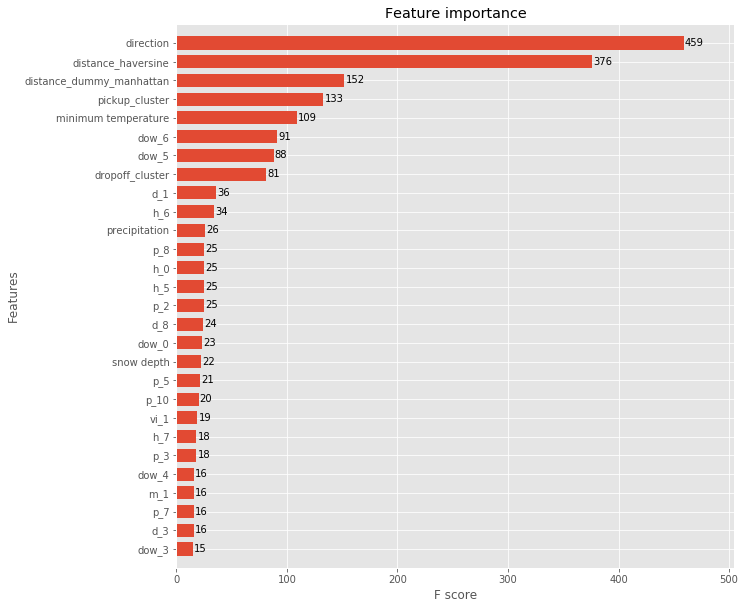

In [64]:
xgb.plot_importance(model, max_num_features=28, height=0.7)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

The feature importance plot above shows which features have the greatest affect on trip duration. It shows the number of times each feature is split on across all boosting rounds in the model, illustrated as a horizontal bar plot. Since there were 88 features, it would be difficult to see all of the feature importances, so the above plot shows the top 27 features (arbitrarily determiend number).

In hindsight, we could have easily removed one of either the haversine distance or the manhattan distance, since they are just numerical manipulations of one another. Anyhow we see that direction, (haversine/manhattan) distance, pickup cluster, and minimum temperature are the biggest factors in determining trip duration for taxis in NYC.

In [ ]:
# to predict one some other test data:
#pred = model.predict(dtest)
#pred = np.exp(pred) - 1